## Imports

In [1]:
from wcs_helper_functions import *
import numpy as np
from scipy import stats, spatial
from random import random
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
%matplotlib inline

## Read Data

In [2]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');
namingData = readNamingData('./WCS_data_core/term.txt');
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt');
munsellInfo = readChipData('./WCS_data_core/chip.txt');
indexCoord = munsellInfo[1]

## Helper Functions

In [3]:
def empty_frequency_map():
    f_map = {
                "A":[0]*41,
                "B":[0]*41,
                "C":[0]*41,
                "D":[0]*41,
                "E":[0]*41,
                "F":[0]*41,
                "G":[0]*41,
                "H":[0]*41,
                "I":[0]*41,
                "J":[0]*41
    }
    return f_map

def f_map_to_matrix(f_map):
    """
    Take a frequency map (dictionary) and turn it into a matrix
    """
    matrix = [f_map["A"],
              f_map["B"],
              f_map["C"],
              f_map["D"],
              f_map["E"],
              f_map["F"],
              f_map["G"],
              f_map["H"],
              f_map["I"],
              f_map["J"]]
    # manually setting these to zero as they are achromatic
    matrix[0][0] = 0
    matrix[9][0] = 0
    return matrix
    
def frequency_hit(f_map,x,y):
    """
    f_map is a frequency map
    x is the index (number)
    y is a letter
    """    
    f_map[y][x]+=1
    return f_map

def contour_plot(f_map):
    x_size = range(0,41)
    y_size = range(0, 10)
    x, y = np.meshgrid(x_size, y_size)
    fig = plt.figure(figsize=(41, 10))
    ax = fig.add_axes([1,1,1,1]) 
    cp = ax.contour(x, y, f_map)
    ax.clabel(cp, inline=True, fontsize=10)
    ax.set_title('Contour Plot: Chip Hit Count Graph')
    ax.set_xlabel('Hue')
    ax.set_ylabel('Lightness')
    return plt

## Contour map of frequencies

In [4]:
f_map = empty_frequency_map()
# Indexing over languages
lang = []
for language_index in range(1, len(fociData)):
    # Indexing over people
    for person_index in range(1, len(fociData[language_index])):
        # Incase of missing data
        if person_index not in fociData[language_index]:
            # print('Skipping fociData [',language_index,'][',person_index,']')
            continue
        # A persons foci data
        person_foci = fociData[language_index][person_index]
        for term in person_foci.values():
            for coord in term:   
                y,x = coord.split(":")
                x=int(x)
                frequency_hit(f_map,x,y)



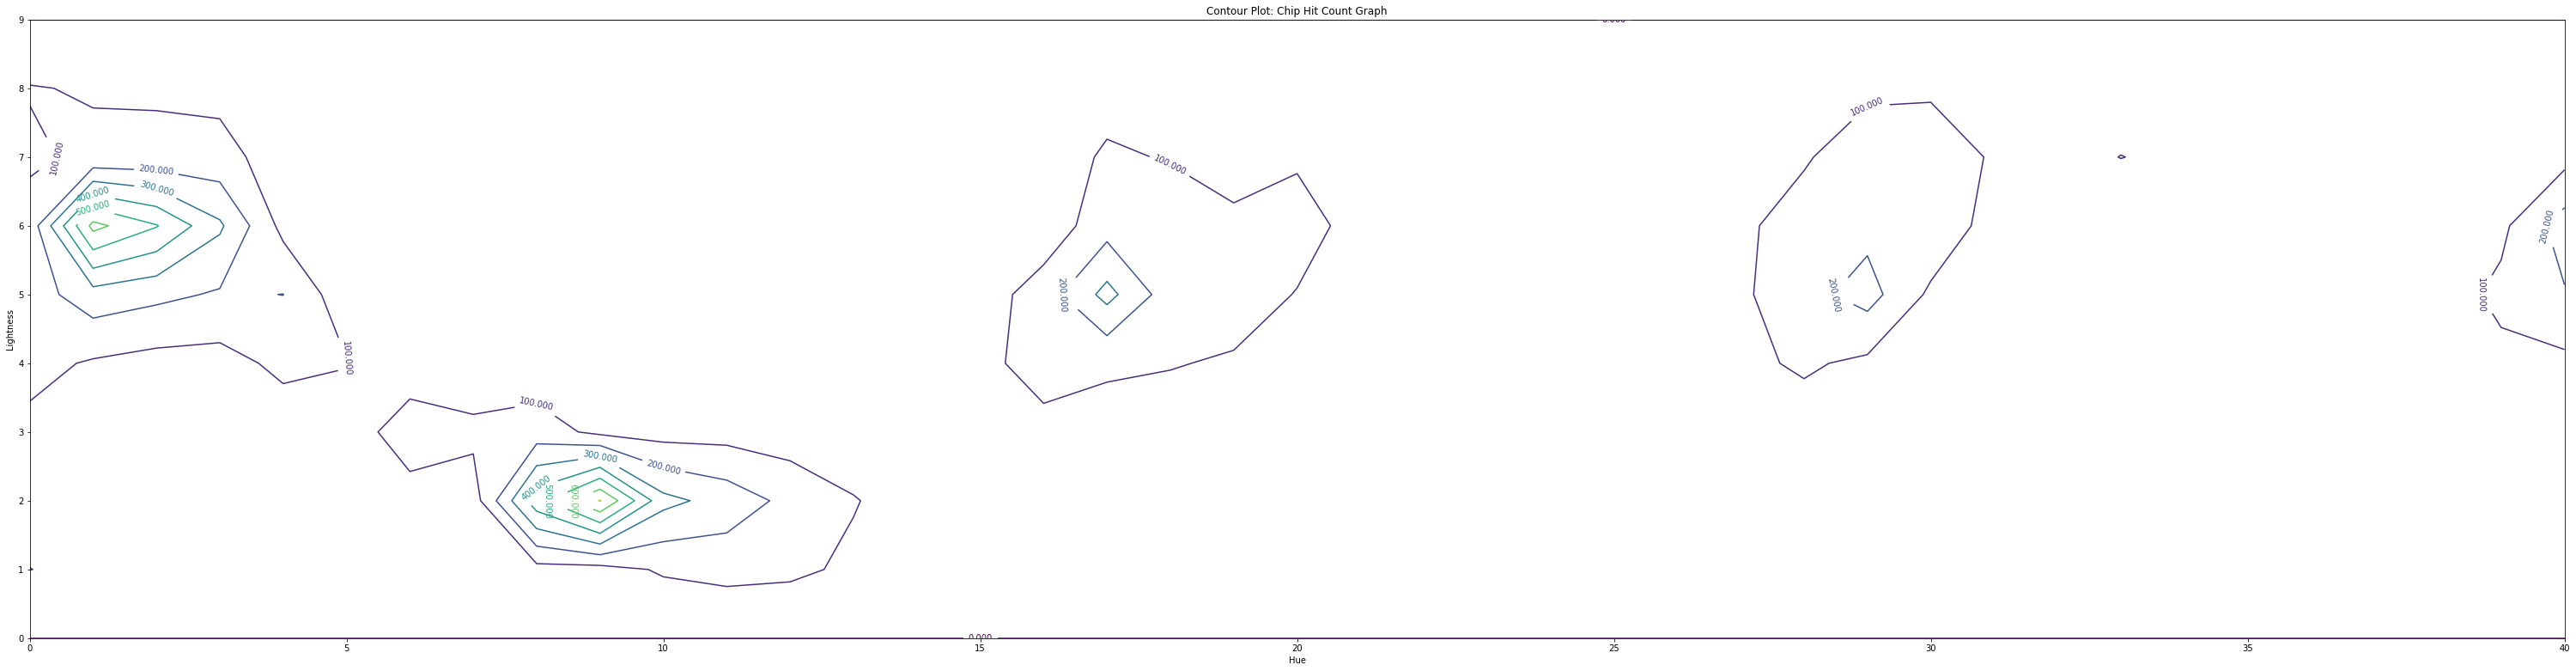

In [5]:
m = f_map_to_matrix(f_map)
graph = contour_plot(m)
graph.show()

## Prototype (Attempt)

This prototype attempt will get the cielab coordinates of all foci in a category and calculate the mean

In psuedo code

for each language in colour naming data

    for each term in that language
    
        get the clab coordinate for that point and save it for that term and language.

use prototype model on that list of coordinates per term

 ### Helper Functions

In [6]:
def get_coords_per_term():
    """
    create a list, where each index in the list is a new language.
    each item in the list will be a dictionary of terms used by that language with each term having a
    value which is a list of cielab coordinates selected for that term
    """
    lang_coord = []
    # for each language in naming data
    for language_index in range(1, len(namingData)):
        # Create a dictionary that will hold the terms (key) and list of coordinates (value)
        term_coord = {}
        # For each person in the language
        for person_index in range(1, len(namingData[language_index])):
            #  naming data missing an index
            if person_index not in namingData[language_index]:
                continue
                
            # A persons foci data
            person_naming = namingData[language_index][person_index] # Format { 1: 'YN', 2:'*', ...}
            for i in person_naming:
                term = person_naming[i]
                # term not in term_coord create a new list
                if term not in term_coord:
                    # create a key value pair where term is the key, and a list with a single coordinate 
                    # is the value
                    term_coord[term] = [cielabCoord[i]]
                # else append coordinate to existing list
                else:
                     term_coord[term].append(cielabCoord[i])

        lang_coord.append(term_coord)
    return lang_coord

def get_centroid(term_dict):
    """
    Takes in a list of cielab coordinates for a single term. get centroid
    """
    centroid_dict = {}
    for term in term_dict:
        coords = term_dict[term]
        mean = np.array(coords).astype(np.float).mean(axis=0)
        centroid_dict[term] = mean
    return centroid_dict

        
        
def find_nearest_example(point):
    """
    Given a dictionary with key value pair where the key is an index(int) 
    and the value a cielab point. return the index of the closest point
    """
    c_p_i = None # Closest point index
    closest_point = None
    min_d = None
    
    for k, v in cielabCoord.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        point, v = comparable(point, v)
        d = spatial.distance.euclidean(v, point)
        if min_d == None or min_d > d:
            min_d = d
            closest_point = v
            c_p_i = k

    return c_p_i

def comparable(point, v):
    """
    take point looking like
    v:  ('96.00', '-.06', '.06')
    point:  [ 37.36797663 -13.71869357   1.733829  ]
    make them comparable in spatial.distance.euclidean()
    """
    p = (point[0], point[1], point[2])
    v = (float(v[0]), float(v[1]), float(v[2]))
    return p ,v



### Model

labels are the ground truth that we will predict.
I guess that means labels should be what that language said is foci?

In [7]:
# def prototype_model(x):
#     """
#     train will be a term/category for a specific language
#     test... not sure what this will be yet
#     """
#     centroids = []
#     for i in range(len(x)):
#         term_dict = x[i]
#         # print(term_dict)
#         get_centroid(term_dict)

def exemplar_model(data):
    """
    x = {
    "LB":[(1,1,1), (1,2,3)]
    }
    # x of dictionaries with key as term and value is list of coord
    
    # x is a dictionary of terms with value being a list of cielab coordinates
    
    """
    f_map = empty_frequency_map()

    for i in range(len(data)):
        if type(data) != list:
            print("i: ", i)
            #print("x: ", x)
            print("type(x): ", type(data))
        term_dict = data[i]
        centroid_dict = get_centroid(term_dict)
        # For each centroid coordinate, find the closest cielab point from chips
        for centroid in centroid_dict.values():
            closest_point_index = find_nearest_example(centroid)
            y , x = indexCoord[closest_point_index] # This is a hit x is index y letter
            x = int(x)
            frequency_hit(f_map,x,y)
    return f_map
            # This maps to munsell space

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [51, 2, 0, 0, 4, 3, 2, 3, 11, 5, 5, 0, 0, 0, 5, 3, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 2, 4, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1], [92, 4, 3, 5, 7, 2, 28, 29, 0, 1, 1, 3, 1, 1, 3, 0, 1, 0, 0, 0, 4, 0, 3, 7, 4, 1, 2, 2, 3, 0, 0, 3, 5, 0, 9, 6, 2, 3, 3, 1, 1], [70, 11, 33, 3, 10, 20, 0, 0, 0, 12, 1, 2, 0, 2, 3, 5, 0, 0, 11, 0, 1, 1, 0, 7, 3, 5, 6, 12, 0, 1, 1, 5, 1, 0, 7, 2, 5, 0, 4, 23, 15], [93, 44, 9, 8, 7, 0, 9, 1, 5, 57, 19, 5, 2, 3, 1, 6, 1, 6, 0, 2, 0, 26, 0, 0, 3, 1, 1, 7, 0, 5, 2, 11, 3, 4, 6, 0, 2, 6, 47, 2, 39], [122, 14, 6, 1, 6, 3, 4, 10, 3, 24, 4, 11, 3, 5, 6, 0, 2, 0, 2, 0, 0, 0, 29, 2, 4, 0, 2, 35, 1, 0, 0, 1, 0, 1, 5, 18, 0, 3, 5, 1, 0], [78, 1, 5, 2, 2, 3, 30, 9, 60, 8, 3, 7, 8, 2, 18, 1, 40, 0, 0, 0, 0, 3, 0, 0, 37, 20, 0, 2, 0, 6, 1, 0, 3, 4, 4, 39, 0, 1, 0, 14, 0], [76, 7, 7, 0, 3, 0, 23, 14, 8, 40, 10, 3, 8, 2, 5, 0, 4, 0, 1, 1, 1, 2, 2, 2, 1, 0,

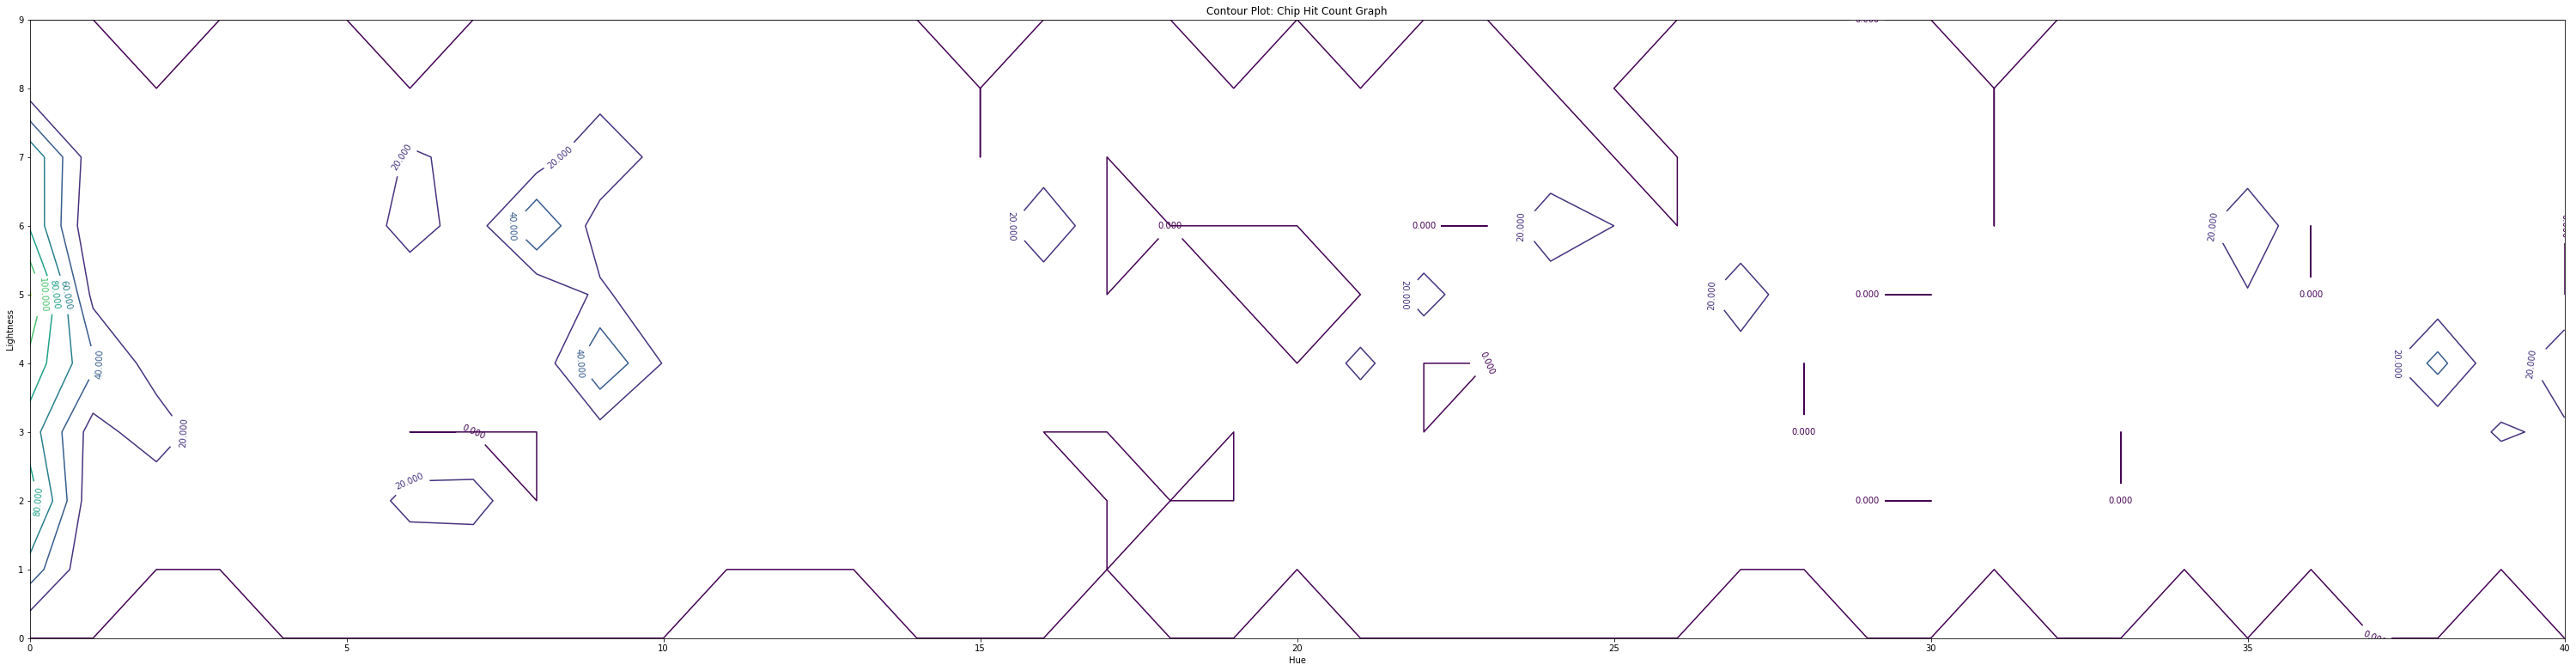

In [10]:
x = get_coords_per_term()
f_map = exemplar_model(x)
m = f_map_to_matrix(f_map)
print(m)
graph = contour_plot(m)
graph.show()

In [9]:
# What I need to do now is with a chip index, find the munsell map index ex: 'D7'